<a href="https://colab.research.google.com/github/enriqueasegura/Quantum-X/blob/master/Example_VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
!pip install git+https://github.com/quantumlib/Cirq
  
import matplotlib.pyplot as plt
from pandas import DataFrame
import cirq
from cirq.ops import CNOT, TOFFOLI
from cirq import Simulator
import random
from sympy import Symbol
from cirq.circuits import InsertStrategy

import matplotlib

#!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf


! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8


  Cloning https://github.com/quantumlib/Cirq to /tmp/pip-req-build-4o99wci4
  Running command git clone -q https://github.com/quantumlib/Cirq /tmp/pip-req-build-4o99wci4
  Created wheel for cirq: filename=cirq-0.8.0.dev0-cp36-none-any.whl size=1303566 sha256=cf39f85ec5124736caff09d9035a9bd983e2a4bf9adb51a67956f2da66a12535
  Stored in directory: /tmp/pip-ephem-wheel-cache-v2zn0vkl/wheels/c9/f4/ee/029123a49c5e2d75d08c2a9f937e207b88f045901db04632a7
Successfully built cirq
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-

#Find the lowest eigenvalue of the following matrix

$\begin{equation*}
H = 
\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & -1 & 1& 0 \\
0 & 1 & -1& 0 \\\
0 & 0 & 0 & 0 
\end{pmatrix}
\end{equation*}
$

using VQE-like circuits, handwritten by yourself.

In general this exercise might be pretty difficult, so below there are a couple of tips. I’ve written them in pale font, so that those of you who embrace the challenge don’t look at them accidentally ;) 
1. It requires decomposing the matrix to sum of Pauli terms. 
2. Decomposition involves only terms consisting of the same matrices, i.e.: II, XX, YY, ZZ and the coefficients are +/- 2.
3. The ansatz you can use is: (IX) CX (RZ I) (HI) |00>, where angle in RZ is your variational parameter.
4. You can find explanation of VQE in this [blogpost](https://www.mustythoughts.com/post/variational-quantum-eigensolver-explained), You can also find links to further resources there.
5. You can just search through all angles for RZ, you don’t need to use any optimizers like gradient descent.



#Borrowed Code to Decompose Two-Qubit Matrix

In [0]:
#borrowed from Michael H. Goerz

def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    #modified from his original xrange because it was not working
    for i in range(4):
        for j in range(4):
            label = labels[i] + ' \otimes ' + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print("%s\t*\t( %s )" % (c2s(a_ij), label))

In [3]:
h_initial = np.array([[0,0,0,0], 
                      [0, -1, 1, 0], 
                      [0,1,-1,0], 
                      [0,0,0,0]])

h_initial

array([[ 0,  0,  0,  0],
       [ 0, -1,  1,  0],
       [ 0,  1, -1,  0],
       [ 0,  0,  0,  0]])

In [4]:
#the actual answer from what we know

min_eigenvalue = np.min(np.linalg.eigvals(h_initial))
print('Eigenvalues of this matrix: ', np.linalg.eigvals(h_initial))
print('Minimum eigenvalue in this matrix (the answer we need to get): ', min_eigenvalue)

Eigenvalues of this matrix:  [ 0. -2.  0.  0.]
Minimum eigenvalue in this matrix (the answer we need to get):  -2.0


#Decomposition of Matrix:

In [5]:
h_decomposed = decompose(h_initial)

-0.5	*	( I \otimes I )
0.5	*	( sigma_x \otimes sigma_x )
0.5	*	( sigma_y \otimes sigma_y )
0.5	*	( sigma_z \otimes sigma_z )


Thus we can write the following equation: 

\begin{eqnarray}
H &=& \frac{-1}{2} ( I_1 \otimes I_2 ) +
      \frac{1}{2}  (X_1 \otimes X_2 ) +
      \frac{1}{2}  (Y_1 \otimes Y_2) +
      \frac{1}{2} (Z_1 \otimes Z_2)
\end{eqnarray}

This represents the decomposition of the hamiltonian of interest for this task. Each tensor product - minus the first term - will be implemented as a quantum circuit below. 

Sidenote: 
\begin{eqnarray}
       \frac{1}{2}  (X_1 \otimes X_2 ) +
      \frac{1}{2}  (Y_1 \otimes Y_2) 
      \end{eqnarray}

This expression commutes. Thus, we can compress this into a single circuit.


#Test Ansatz

(IX) CX (RZ I) (HI) |00> 

I used [this paper](https://arxiv.org/pdf/1909.05074.pdf), specifically the example given by figure 4, to write the circuit in accordance to this ansatz. 

In [0]:
def ansatz_task(angle, num_qubits):
  q = [cirq.LineQubit(i) for i in range(2)]
  
  yield cirq.H(q[0])
  rot = cirq.rz(rads=angle)
  yield rot(q[0])

  yield cirq.CX(*q)
  yield cirq.X(q[1])
  #yield cirq.X(q[1])
  yield cirq.measure(*q)

In [0]:
def ansatz_explorer(num_qubits, num_reps):
  angle_range = np.arange(0, 2*np.pi, 0.01)
  energy_arr = []
  for angle in angle_range:
    
    #create circuit with current variation
    curr_circuit = cirq.Circuit()
    curr_circuit.append(ansatz_task(angle, num_qubits))

    #simulate this circuit 
    curr_simulator = cirq.Simulator()

    curr_results = curr_simulator.run(curr_circuit, repetitions=num_reps)
  
    #keep the measured keys and values 
    s_k, s_v= zip(*curr_results.measurements.items())

    #convert into booleans from sp|in values
    curr_state_values = 1 - 2*np.array(s_v).astype(np.int32)

    #get the expectation value (the average of the counts)
    #I keep double the variables because I want to remind myself of the distinction between this task and the context 
    #of Farhi's paper.
    curr_predicted_label_value = np.mean(curr_state_values)

    #keep the current expected energy:
    curr_energy = np.mean(curr_state_values)
    energy_arr.append(curr_energy)
    #print('current angle: ', angle, 'current energy: ', curr_energy)

  return(angle_range, energy_arr)

In [0]:
test_explorer = ansatz_explorer(2, 1000)

In [0]:
"""
plt.figure(figsize=(10,5))

#plt.plot(test_optimization[0], label=r'$X_1\otimes X_2$', color='#FF6C0C', linestyle='-')
plt.plot(test_explorer[0], test_explorer[1], label=r'$Y_1\otimes Y_2$', color='crimson', linestyle='-')
#plt.plot(test_optimization[6], label=r'$Z_1\otimes Z_2$', color='#00693e', linestyle='-')

plt.legend(fontsize=15, bbox_to_anchor=(1.24,1))

plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\mathcal{L}$',fontsize=25)

plt.title(r'Evolution of $\mathcal{L}$ as VQE searches for Ground State in $\mathcal{H}$', fontsize=25)

plt.tight_layout()

plt.subplots_adjust(top=0.7)
"""

# Code to Develop Quantum Circuits from Given Matrix to Represent Decomposition:

I followed the following [paper](https://arxiv.org/pdf/1108.4318.pdf), as well as Nielsen and Chuang's exercise 4.31 to develop these circuits. 

In [0]:
#this is from the example of the blogs I used to build a sample circuit
def ansatz(th, input_q):
  rot= cirq.YPowGate(exponent=th)
  yield rot(input_q)

#after this, I develop the following functions to develop the required circuits to implement the
#decomposition circuit shown above. 

def XX_circuit(th1, num_q):
  q = [cirq.LineQubit(i) for i in range(num_q)]

  #Change of basis 
  yield cirq.H(q[0])
  yield cirq.H(q[1])
  
  #first rotation
  yield cirq.CNOT(*q)
  rot= cirq.rz(rads=th1)
  yield rot(q[1])
  yield cirq.CNOT(*q)

  #Change of basis 
  yield cirq.H(q[0])
  yield cirq.H(q[1])

  #second rotation Y since it's an X operator
  #rot2 = cirq.ry(th2)
  #yield rot2(q[0])
  #yield rot2(q[1])

  yield cirq.measure(*q)

In [0]:
"""
c = cirq.Circuit()
c.append(XX_circuit(1.2, 2))

print(c)

c_s = cirq.Simulator()

r = c_s.run(c, 1000)
cirq.plot_state_histogram(r)
"""

In [0]:
def YY_circuit(th1, num_q):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_q)]
  
  #entangle the qubits and take them to the measurement basis 
  yield cirq.CNOT(q[1], q[0])
  yield cirq.H(q[1])

  #bring the ansatz 
  yield cirq.CNOT(q[0], q[1])
  rot= cirq.rz(rads=th1)
  yield rot(q[1])
  yield cirq.CNOT(q[0], q[1])

  #and now, start reversing the process 
  yield cirq.H(q[1])
  yield cirq.CNOT(q[1], q[0])

  yield cirq.measure(*q)
  return c

In [0]:
def ZZ_circuit(th1, num_q):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_q)]

  yield cirq.H(q[0])
  yield cirq.H(q[1])

  yield cirq.CNOT(q[0], q[1])
  #first rotation 

  rot = cirq.ZPowGate(exponent=th1)
  yield rot(q[1])
  #yield rot1(q[1])
  yield cirq.CNOT(q[0], q[1])

  yield cirq.H(q[0])
  yield cirq.H(q[1])

  yield cirq.measure(*q)
  return c

In [0]:
"""
c = cirq.Circuit()
c.append(ZZ_circuit(1.3, 2))

print(c)

c_s = cirq.Simulator()

r = c_s.run(c, 1000)
cirq.plot_state_histogram(r)
"""

In [0]:
#Since X_1\otimes X_2 + Y_1 \otimes Y_2 commute and can be defined into a simple, 
# much simpler circuit - thanks QCSE!

def XX_YY_circuit(th1, num_q):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_q)]

  yield cirq.CNOT(q[0], q[1])
  #first rotation 

  rot = cirq.XPowGate(exponent=th1)
  yield rot(q[1])
  #yield rot1(q[1])
  yield cirq.CNOT(q[0], q[1])

  yield cirq.measure(*q)
  return c 

# Function Wrapper

In [0]:
def VQE_Circuit(th1, th2, num_q):
  #the circuits for each hamiltonian
  #not to be confused with the quantum gates!!!!!
  #cXX = cirq.Circuit()
  #cYY = cirq.Circuit()
  cXX_YY = cirq.Circuit()
  cZZ = cirq.Circuit()

  #develop the circuits to represent the hamiltonian
  cXX_YY.append(XX_YY_circuit(th1, num_q))
  #cYY.append(YY_circuit(th2, num_q))
  cZZ.append(ZZ_circuit(th2, num_q))

  return(cXX_YY, cZZ)

#Gradient Descent on Optimization Code

Last year, and the first introduction to quantum computing I had, was through Farhi et al's paper on quantum neural networks for state classification. 

I borrow their implementation of Gradient Descent specifically for this VQE optimization of the circuits. 

It is worth saying that it matters a great deal the seed values each gate on the quantum circuit representing the ansatz.

In [0]:
def VQE_Optimization(th1, th2, num_q, num_reps):
  
  #get the holders of the actual data 
  
  angle_rot1_XX_YY = []
  angle_rot1_ZZ = []

  #keep the energy
  energy = []
  
  #keep the loss for gradient descent and set the learning rate

  learning_rate = 0.01
  
  loss_XX_YY = []
  loss_ZZ = [] 

  energy_XX_YY =[]
  energy_ZZ = []
  
  count = 0 

  coef1, coef2, coef3, coef4 = -0.5, 0.5, 0.5, 0.5

  status = 'not done'
  #a hard cutoff because, let's face it, it's already overkill at 5000 iterations.
  while count < 5000:
    
    #seed values:
    angle_rot1_XX_YY.append(th1)
    angle_rot1_ZZ.append(th2)


    #call the circuit function to make the circuits 
    current_VQE = VQE_Circuit(th1, th2, num_q)

    curr_simulator_XX_YY = cirq.Simulator()
    curr_simulator_ZZ = cirq.Simulator()
    
    results_XX_YY = curr_simulator_XX_YY.run(current_VQE[0], repetitions=num_reps)
    results_ZZ = curr_simulator_ZZ.run(current_VQE[1], repetitions=num_reps)
    
    
    s_kXX_YY, s_vXX_YY= zip(*results_XX_YY.measurements.items())
    s_kZZ, s_vZZ= zip(*results_ZZ.measurements.items())
    
    curr_state_values_XX_YY = 1 - 2*np.array(s_vXX_YY).astype(np.int32)
    curr_state_values_ZZ = 1 - 2*np.array(s_vZZ).astype(np.int32)

    curr_predicted_label_value_XX_YY = np.mean(curr_state_values_XX_YY)
    curr_predicted_label_value_ZZ = np.mean(curr_state_values_ZZ)

    current_loss_value_XX_YY = 1 - np.square(curr_predicted_label_value_XX_YY)
    current_loss_value_ZZ = 1 - np.square(curr_predicted_label_value_ZZ)

    loss_XX_YY.append(current_loss_value_XX_YY)
    loss_ZZ.append(current_loss_value_ZZ)
    
    current_gradient_value_XX_YY = 2*curr_predicted_label_value_XX_YY
    current_gradient_value_ZZ = 2*curr_predicted_label_value_ZZ
    
    current_grad_square_XX_YY = np.square(current_gradient_value_XX_YY)
    current_grad_square_ZZ = np.square(current_gradient_value_ZZ)
    
    """
    Decomposition of Hamiltonian:

    -0.5	*	( I \otimes I )
    0.5	*	( sigma_x \otimes sigma_x )
    0.5	*	( sigma_y \otimes sigma_y )
    0.5	*	( sigma_z \otimes sigma_z )
    """
    #laying down the energy expectation terms
    term1 = coef1*1
    #term2 = coef2*curr_predicted_label_value_XX
    term2 = coef2*curr_predicted_label_value_XX_YY
    term3 = coef3*curr_predicted_label_value_ZZ

    energy_XX_YY.append(curr_predicted_label_value_XX_YY)
    energy_ZZ.append(curr_predicted_label_value_ZZ)
    
    curr_energy = term1 + term2 + term3

    #keep energy 
    energy.append(curr_energy)


    #now do the SGD
    #print('current count: ', count)
    #print('current count: ', count,'current energy:', curr_energy, 'current loss:', [current_loss_value_XX_YY, current_loss_value_ZZ])
    #print('current params:', [th1, th2, th3, th4, th5])
    #print('current count: ', count,'current energy:', curr_energy)

    if np.absolute(current_loss_value_XX_YY) < 1e-5 and np.absolute(current_loss_value_ZZ) < 1e-5:
    #elif np.absolute(target_difference) < 1e-3:
      status = 'done'
      print('Done! Final Weights: ',angle_rot1_XX_YY[-1], angle_rot1_ZZ[-1], 'Final Energy:', energy[-1])
      break
    
    else:

      th1 = th1 - learning_rate * (current_loss_value_XX_YY / current_grad_square_XX_YY) * current_gradient_value_XX_YY
      
      th2 = th2 - learning_rate * (current_loss_value_ZZ / current_grad_square_ZZ) *  current_gradient_value_ZZ
      count+=1

  return(angle_rot1_XX_YY, angle_rot1_ZZ, loss_XX_YY, loss_ZZ,  energy, energy_XX_YY, energy_ZZ)

#Testing Optimization Algorithm

Below you will find the values used using the blogs linked on the Google doc. 

For the future: important to work out the optimal repetition.

In [0]:
# Arbitrary value of theta
th1 = np.random.uniform(0, 2*np.pi)
th2 = np.random.uniform(0, 2*np.pi)

num_q = 2

num_reps = 1000

In [85]:
test_optimization = VQE_Optimization(th1, th2, num_q, num_reps)

Done! Final Weights:  2.035478082787086 0.017075850749641828 Final Energy: 0.5


# Results

In [0]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 

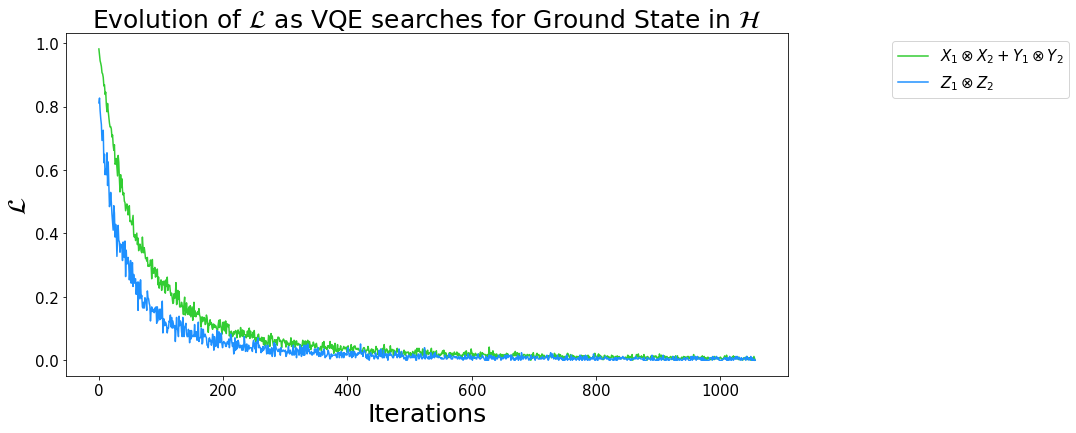

In [86]:
plt.figure(figsize=(16,7))

plt.plot(test_optimization[2], label=r'$X_1\otimes X_2 + Y_1\otimes Y_2$', color='limegreen', linestyle='-')
plt.plot(test_optimization[3], label=r'$Z_1\otimes Z_2$', color='dodgerblue', linestyle='-')

plt.legend(fontsize=15, bbox_to_anchor=(1.4,1))

plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\mathcal{L}$',fontsize=25)

plt.title(r'Evolution of $\mathcal{L}$ as VQE searches for Ground State in $\mathcal{H}$', fontsize=25)

plt.tight_layout()

plt.subplots_adjust(top=0.8)

In [96]:
print('The following quantities are not adjusted by the .5 factor')
print('********************')
print('Observed Energy on Z \otimes Z: ', test_optimization[6][-1])
print('Observed Energy on X \otimes X + Y \otimes Y: ', test_optimization[5][-1])
print('Expected Energy from I \otimes I: ', 1)

The following quantities are not adjusted by the .5 factor
********************
Observed Energy on Z \otimes Z:  1.0
Observed Energy on X \otimes X + Y \otimes Y:  1.0
Expected Energy from I \otimes I:  1


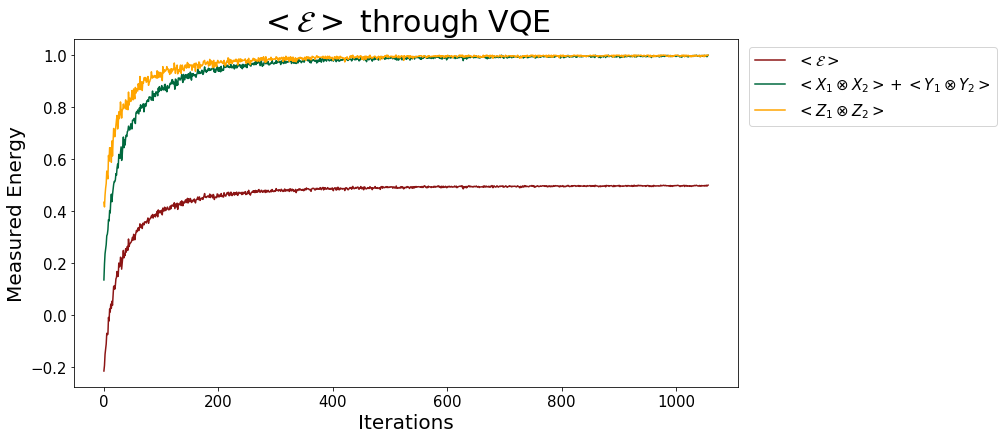

In [100]:
plt.figure(figsize=(15,7))

plt.plot(test_optimization[4], linestyle='-', color='#8c1515', label='$< \mathcal{E} >$')
plt.plot(test_optimization[5], color='#00693e', linestyle='-', label=r'$< X_1 \otimes X_2> + <Y_1 \otimes Y_2 >$')
plt.plot(test_optimization[6], color='orange', linestyle='-', label=r'$< Z_1 \otimes Z_2 >$')

plt.legend(fontsize=15, bbox_to_anchor=(1.4,1))
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('Measured Energy', fontsize=20)
plt.title(r'$<\mathcal{E}>$ through VQE', fontsize=30)

plt.tight_layout()

plt.subplots_adjust(top=0.8)

#Resulting Circuits that Comprise Hamiltonian

In [101]:
#resultant circuits

op_c = VQE_Circuit(test_optimization[0][-1],test_optimization[1][-1],num_q)
print('XX+YY Circuit:')
print(op_c[0])
print('*******')
print('ZZ Circuit:')
print(op_c[1])

XX+YY Circuit:
0: ───@─────────────@───M───
      │             │   │
1: ───X───X^0.035───X───M───
*******
ZZ Circuit:
0: ───H───@─────────────@───H───M───
          │             │       │
1: ───H───X───Z^0.017───X───H───M───


#Visualization of Evolution of Gate Parameters on Circuit

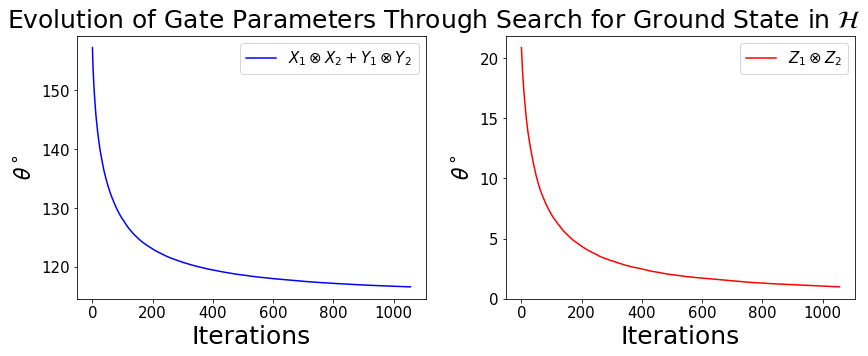

In [102]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(np.rad2deg(test_optimization[0]), label=r'$X_1\otimes X_2 +Y_1\otimes Y_2$ ', color='blue', linestyle='-')
#plt.plot(test_optimization[6], label=r'$Z_1\otimes Z_2$', color='#00693e', linestyle='-')
plt.legend(fontsize=15, loc='best')


plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\mathcal{\theta}^\circ$',fontsize=25)

plt.subplot(122)
plt.plot(np.rad2deg(test_optimization[1]), label=r'$Z_1\otimes Z_2$', color='red', linestyle='-')
plt.suptitle(r'Evolution of Gate Parameters Through Search for Ground State in $\mathcal{H}$', fontsize=25)
plt.legend(fontsize=15, loc='best')
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\mathcal{\theta} ^\circ$',fontsize=25)

plt.tight_layout()

plt.subplots_adjust(top=.9)